In [ ]:
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import os
nltk.download('punkt')
nltk.download('stopwords')
import pandas as pd
import seaborn as sns
from nltk.tokenize import sent_tokenize
from collections import Counter
import math
import string

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
def preprocess_text(text):
    tokens = word_tokenize(text)
    tokens = [token.lower() for token in tokens]
    stop_words = set(stopwords.words('english'))
    punctuations = ['"', '.', '(', ')', ',', '?', ';', ':', "''", '``']
    filtered_tokens = [w for w in tokens if not w in stop_words and not w in punctuations]
    return filtered_tokens

def generate_trigrams(tokens):
    trigrams = []
    for i in range(len(tokens) - 2):
        t = (tokens[i], tokens[i + 1], tokens[i + 2])
        trigrams.append(t)
    return trigrams



def calculate_jaccard_and_containment(trigrams_o, trigrams_p):
    s = sum(1 for t in trigrams_p if t in trigrams_o)
    J = s / (len(trigrams_o) + len(trigrams_p) - s) if (len(trigrams_o) + len(trigrams_p) - s) > 0 else 0
    C = s / len(trigrams_o) if len(trigrams_o) > 0 else 0
    return J, C

def lcs(l1, l2):
    s1 = preprocess_text(l1)
    s2 = preprocess_text(l2)

    dp = [[None] * (len(s1) + 1) for _ in range(len(s2) + 1)]

    for i in range(len(s2) + 1):
        for j in range(len(s1) + 1):
            if i == 0 or j == 0:
                dp[i][j] = 0
            elif s2[i - 1] == s1[j - 1]:
                dp[i][j] = dp[i - 1][j - 1] + 1
            else:
                dp[i][j] = max(dp[i - 1][j], dp[i][j - 1])
    return dp[len(s2)][len(s1)]

def calculate_lcs_text(orig, plag):
    return lcs(orig, plag)


def calculate_lcs_sentence_similarity(sent_o, sent_p):
    max_lcs = 0
    sum_lcs = 0

    for sent_plag in sent_p:
        for sent_orig in sent_o:
            l = lcs(sent_plag, sent_orig)
            max_lcs = max(max_lcs, l)
        sum_lcs += max_lcs
        max_lcs = 0

    return sum_lcs / len(word_tokenize(" ".join(sent_p))) if len(sent_p) > 0 else 0

In [ ]:
def calculate_tf(text_tokens):
    tf = Counter(text_tokens)
    total_terms = len(text_tokens)
    tf = {word: count / total_terms for word, count in tf.items()}
    return tf

def calculate_idf(corpus):
    idf = {}
    total_documents = len(corpus)
    all_tokens = set(token for doc in corpus for token in doc)

    for token in all_tokens:
        containing_docs = sum(1 for doc in corpus if token in doc)
        idf[token] = math.log(total_documents / (1 + containing_docs)) + 1

    return idf

def calculate_tf_idf(tf, idf):
    tf_idf = {word: tf[word] * idf[word] for word in tf.keys()}
    return tf_idf

def calculate_cosine_similarity(tf_idf1, tf_idf2):
    intersection = set(tf_idf1.keys()) & set(tf_idf2.keys())
    numerator = sum(tf_idf1[word] * tf_idf2[word] for word in intersection)

    sum1 = sum(tf_idf1[word]**2 for word in tf_idf1.keys())
    sum2 = sum(tf_idf2[word]**2 for word in tf_idf2.keys())
    denominator = math.sqrt(sum1) * math.sqrt(sum2)

    if not denominator:
        return 0.0
    return numerator / denominator


In [ ]:
def plot_results(df):
    plt.figure(figsize=(20, 10))

    # Plot Jaccard Coefficient
    plt.subplot(1, 4, 1)
    sns.barplot(x='Category',hue='Category', y='Jaccard', data=df,legend=False, palette='viridis')
    plt.xlabel('Category')
    plt.ylabel('Jaccard Coefficient')
    plt.title('Jaccard Coefficient by Category')
    plt.xticks(rotation=45)
    plt.ylim(0, 1)

    # Plot Containment Measure
    plt.subplot(1, 4, 2)
    sns.barplot(x='Category',hue='Category',legend=False ,y='Containment', data=df, palette='viridis')
    plt.xlabel('Category')
    plt.ylabel('Containment Measure')
    plt.title('Containment Measure by Category')
    plt.xticks(rotation=45)
    plt.ylim(0, 1)

    # Plot LCS Sentence Similarity Score
    plt.subplot(1, 4, 3)
    sns.barplot(x='Category',hue='Category', legend=False ,y='LCS Sentence Similarity', data=df, palette='viridis')
    plt.xlabel('Category')
    plt.ylabel('LCS Sentence Similarity Score')
    plt.title('LCS Sentence Similarity Score by Category')
    plt.xticks(rotation=45)
    plt.ylim(0, 1)

    # Plot Cosine Similarity Similarity Score
    plt.subplot(1, 4, 4)
    sns.barplot(x='Category', hue='Category',legend=False,y='Cosine Similarity', data=df, palette='viridis')
    plt.xlabel('Category')
    plt.ylabel('Cosine Similarity Score')
    plt.title('Cosine Similarity Score by Category')
    plt.xticks(rotation=45)
    plt.ylim(0, 1)

    plt.tight_layout()
    plt.show()


In [ ]:
def extract_categories(metadata_directory, num_files):
    categories = []
    for i in range(1, num_files + 1):
        metadata_filename = f'{i}-metadata.txt'
        metadata_path = os.path.join(metadata_directory, metadata_filename)
        with open(metadata_path, 'r') as f:
            metadata = f.read()
        if 'Paraphrase: Yes' in metadata:
            category = 'paraphrase'
        else:
            category = 'non-paraphrase'
        categories.append(category)
    return categories


In [ ]:
def read_file(file_path):
    if not os.path.exists(file_path):
        print(f"Error: {file_path} does not exist.")
        return ""

    with open(file_path, "r") as f:
        content = f.read().strip()

    if len(content) == 0:
        print(f"Warning: {file_path} is empty.")

    return content


In [ ]:
def read_and_process_texts(metadata_directory, num_files):
    results = {
        'Category': [],
        'Jaccard': [],
        'Containment': [],
        'LCS Sentence Similarity': [],
        'Cosine Similarity': []
    }

    categories = extract_categories(metadata_directory, num_files)

    for i in range(1, num_files + 1):
        original_filename = f'{i}-original.txt'
        paraphrase_filename = f'{i}-paraphrase.txt'
        category = categories[i - 1]

        orig = read_file(os.path.join(metadata_directory, original_filename))
        plag = read_file(os.path.join(metadata_directory, paraphrase_filename))

        if len(orig) == 0 or len(plag) == 0:
            print(f"Skipping file pair {i} due to empty content.")
            continue

        filtered_tokens_o = preprocess_text(orig)
        filtered_tokens_p = preprocess_text(plag)

        trigrams_o = generate_trigrams(filtered_tokens_o)
        trigrams_p = generate_trigrams(filtered_tokens_p)

        J, C = calculate_jaccard_and_containment(trigrams_o, trigrams_p)
        L = calculate_lcs_text(orig, plag)

        sent_o = sent_tokenize(orig)
        sent_p = sent_tokenize(plag)
        lcs_sentence_similarity = calculate_lcs_sentence_similarity(sent_o, sent_p)


        tf_orig = calculate_tf(filtered_tokens_o)
        tf_plag = calculate_tf(filtered_tokens_p)
        idf = calculate_idf([filtered_tokens_o, filtered_tokens_p])

        tf_idf_orig = calculate_tf_idf(tf_orig, idf)
        tf_idf_plag = calculate_tf_idf(tf_plag, idf)

        cosine_similarity = calculate_cosine_similarity(tf_idf_orig, tf_idf_plag)

        results['Category'].append(category)
        results['Jaccard'].append(J)
        results['Containment'].append(C)
        results['LCS Sentence Similarity'].append(lcs_sentence_similarity)
        results['Cosine Similarity'].append(cosine_similarity)

    df = pd.DataFrame(results)
    return df


In [ ]:
num_files = 4000
metadata_directory = '/content'
df = read_and_process_texts(metadata_directory, num_files)

In [ ]:
df.head(5)

,Category,Jaccard,Containment,LCS Sentence Similarity,Cosine Similarity
0,paraphrase,0.047619,0.095238,0.204545,0.427685
1,paraphrase,0.161290,0.263158,0.292683,0.347656
2,paraphrase,0.000000,0.000000,0.095238,0.169242
3,paraphrase,0.032258,0.055556,0.257143,0.363283
4,non-paraphrase,0.214286,0.333333,0.269231,0.499949


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
def plot_combined_results(df):
    plt.figure(figsize=(14, 10))

    df_melted = df.melt(id_vars='Category',
                        value_vars=['Jaccard', 'Containment', 'LCS Sentence Similarity','Cosine Similarity'],
                        var_name='Measure',
                        value_name='Value')

    # Plot
    sns.barplot(x='Category', y='Value', hue='Measure', data=df_melted, palette='viridis')

    plt.xlabel('Category')
    plt.ylabel('Value')
    plt.title('Comparison of Similarity Measures by Category')
    plt.xticks(rotation=45)
    plt.legend(title='Measure')
    plt.ylim(0, 1)
    plt.tight_layout()
    plt.show()


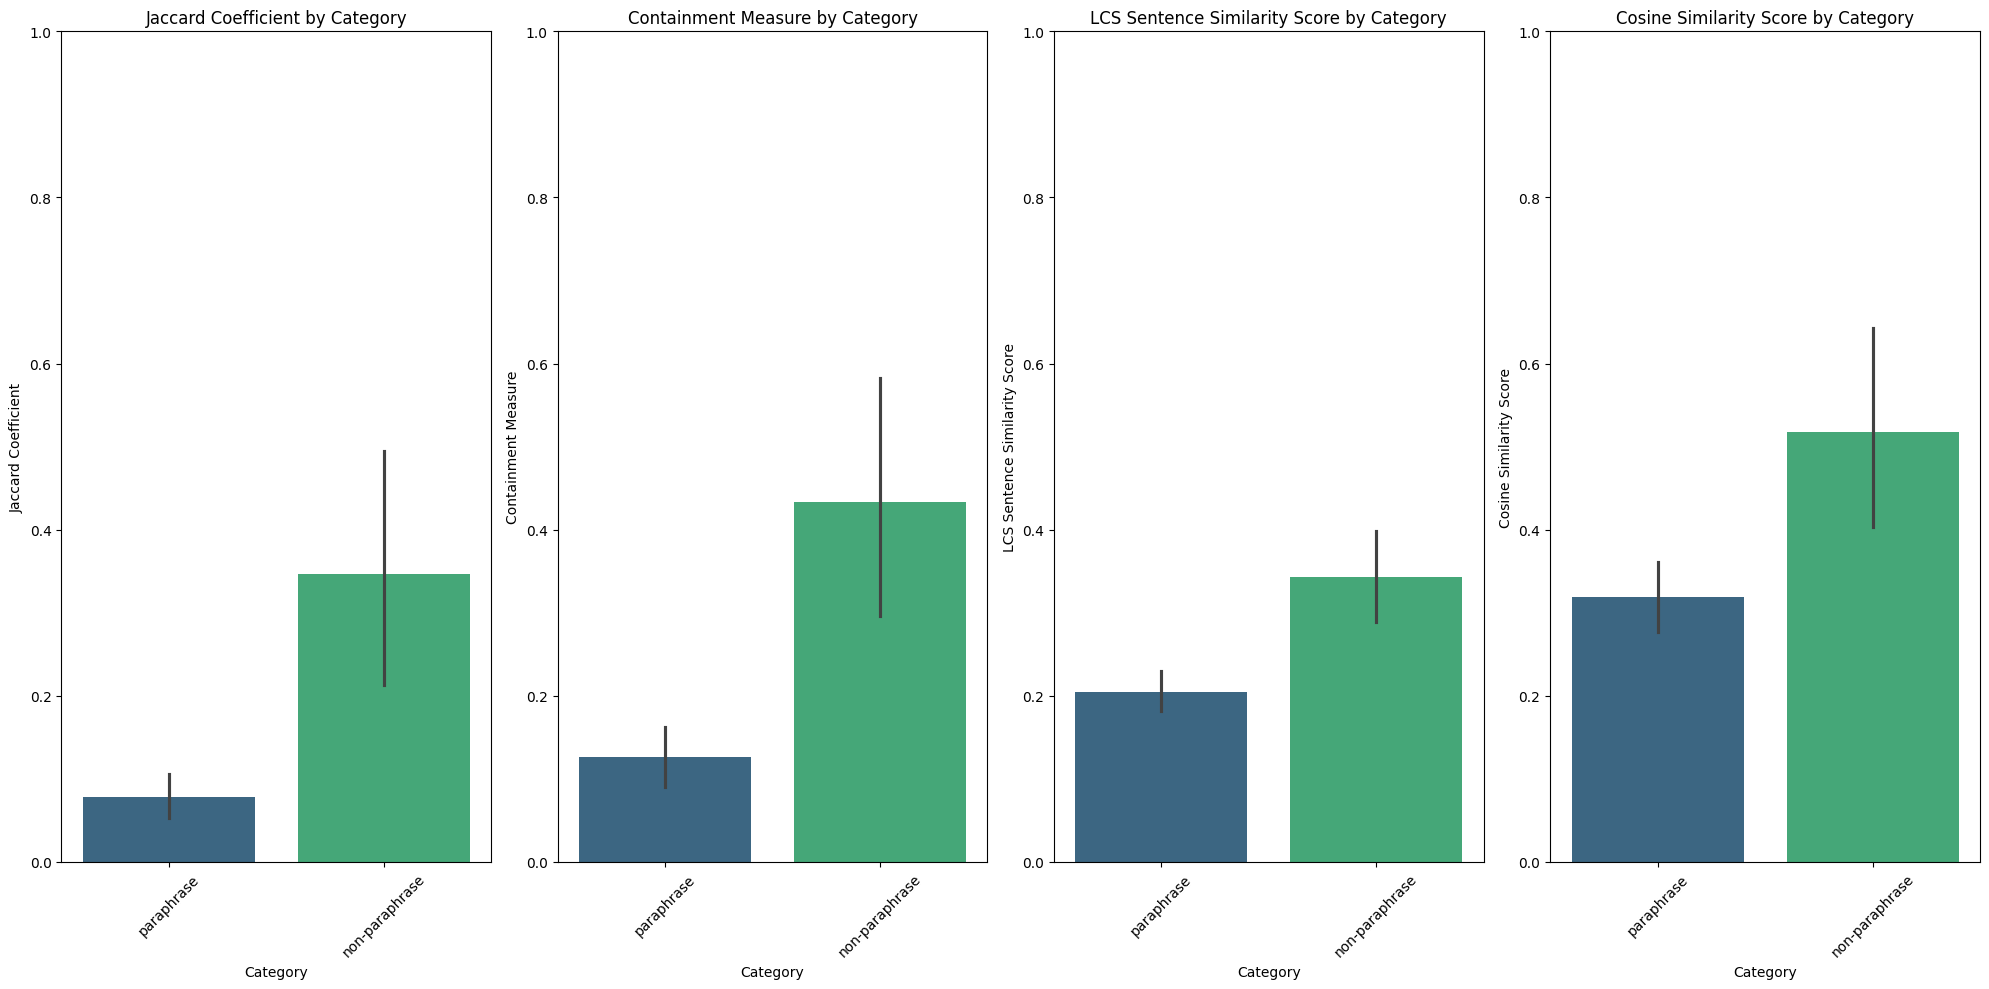

In [ ]:
plot_results(df)

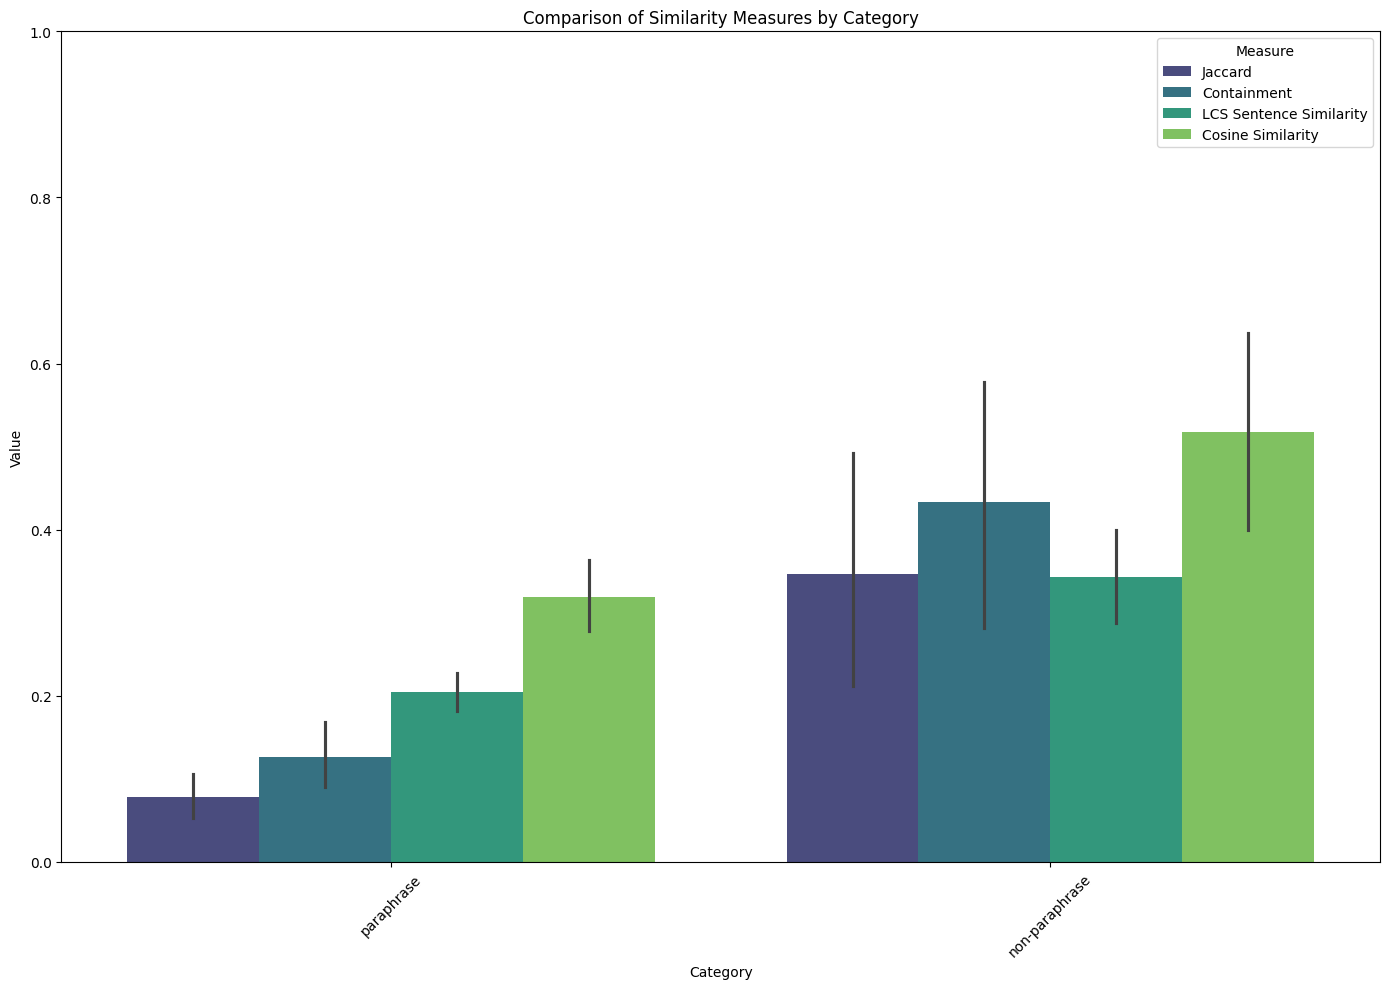

In [ ]:
plot_combined_results(df)